In [11]:
import math
import time
import requests
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # 그래프 저장을 위해 추가

# 로컬 모듈 임포트 (previous_chapters.py가 필요합니다)
from previous_chapters import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split,
    SpamDataset,
    GPTModel,
    download_model,
    calc_accuracy_loader,
    train_classifier_simple,
    plot_values # 그래프 그리기 함수 추가
)


In [12]:
# -----------------------------------------------------------------------------
# 1. 설정 및 하이퍼파라미터
# -----------------------------------------------------------------------------
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
    "emb_dim": 768, "n_layers": 12, "n_heads": 12
}

BATCH_SIZE = 8
NUM_EPOCHS = 5
LEARNING_RATE = 8e-4
LORA_RANK = 16
LORA_ALPHA = 16


In [13]:
###중요: LoRA 구현 부분
# -----------------------------------------------------------------------------
# 2. LoRA 클래스 및 함수 정의
# -----------------------------------------------------------------------------
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        """
        LoRA(Low-Rank Adaptation) 레이어 초기화
        """
        super().__init__()
        self.A = nn.Parameter(torch.empty(in_dim, rank))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        
        self.alpha = alpha
        self.rank = rank

    def forward(self, x):
        # region [LoRA 어댑터 적용]
        x = (self.alpha / self.rank) * (x @ self.A @ self.B)
        # endregion
        return x

class LinearWithLoRA(nn.Module):
    """
    기존의 Linear 레이어를 감싸서 LoRA 어댑터를 추가한 클래스
    """
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        # region [기존 Linear와 LoRA 출력 합산]
        return self.linear(x) + self.lora(x)
        # endregion
        
def replace_linear_with_lora(model, rank, alpha):
    """
    모델 내의 모든 Linear 레이어를 찾아 LoRA가 적용된 레이어로 교체
    """
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # 기존 Linear 레이어를 LinearWithLoRA로 교체
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # 재귀 호출
            replace_linear_with_lora(module, rank, alpha)

In [14]:
def main():
    # 시드 설정
    torch.manual_seed(123)
    
    # 장치 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 장치: {device}")

    # --- 데이터셋 준비 ---
    print("데이터셋 준비 중...")
    url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
    zip_path = "datas/sms_spam_collection.zip"
    extracted_path = "datas/sms_spam_collection"
    data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

    try:
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
    except (requests.exceptions.RequestException, TimeoutError):
        # 백업 URL 시도
        url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

    df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
    balanced_df = create_balanced_dataset(df)
    balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

    train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
    
    # 임시 파일 저장 (Dataset 클래스 사용을 위해)
    train_df.to_csv("datas/train.csv", index=None)
    validation_df.to_csv("datas/validation.csv", index=None)
    test_df.to_csv("datas/test.csv", index=None)

    tokenizer = tiktoken.get_encoding("gpt2")
    train_dataset = SpamDataset("datas/train.csv", max_length=None, tokenizer=tokenizer)
    val_dataset = SpamDataset("datas/validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
    test_dataset = SpamDataset("datas/test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, drop_last=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, drop_last=False)

    # --- 모델 준비 ---
    print("모델 로드 중...")

    file_name = "gpt2-small-124M.pth"
    model_path = f"./models/gpt2/{file_name}"
    download_model(file_name, model_path)

    # Policy Model (학습 대상)
    model = GPTModel(BASE_CONFIG)
    model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
    model.to(device)

    # 출력 헤드 교체 (분류용)
    num_classes = 2
    model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
    
    # --- LoRA 적용 ---
    print("LoRA 레이어 적용 및 파라미터 동결 중...")
    # 1. 모든 파라미터 동결
    for param in model.parameters():
        param.requires_grad = False
    
    # 2. Linear 레이어를 LoRA로 교체 (LoRA 파라미터는 새로 생성되므로 requires_grad=True 상태)
    replace_linear_with_lora(model, rank=LORA_RANK, alpha=LORA_ALPHA)
    
    model.to(device)

    # 학습 가능 파라미터 확인
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"총 학습 가능 LoRA 파라미터 수: {total_params:,}")

    # --- 학습 실행 ---
    print("학습 시작...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
    
    start_time = time.time()
    # 반환값 캡처 (loss 및 accuracy 기록)
    train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=NUM_EPOCHS, eval_freq=50, eval_iter=5,
    )
    end_time = time.time()
    print(f"학습 완료 (소요 시간: {(end_time - start_time) / 60:.2f}분)")

    # --- 결과 시각화 (Loss) ---
    print("학습 결과 시각화 중...")
    epochs_tensor = torch.linspace(0, NUM_EPOCHS, len(train_losses))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
    
    # plot_values 함수 호출
    plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")
    
    # --- 최종 평가 ---
    print("최종 모델 평가 중...")
    train_acc = calc_accuracy_loader(train_loader, model, device)
    val_acc = calc_accuracy_loader(val_loader, model, device)
    test_acc = calc_accuracy_loader(test_loader, model, device)

    print(f"훈련 정확도: {train_acc*100:.2f}%")
    print(f"검증 정확도: {val_acc*100:.2f}%")
    print(f"테스트 정확도: {test_acc*100:.2f}%")

사용 장치: cuda
데이터셋 준비 중...
datas/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.
모델 로드 중...
LoRA 레이어 적용 및 파라미터 동결 중...
총 학습 가능 LoRA 파라미터 수: 2,666,528
학습 시작...
Ep 1 (Step 000000): Train loss 1.910, Val loss 2.119
Ep 1 (Step 000050): Train loss 0.134, Val loss 0.165
Ep 1 (Step 000100): Train loss 0.209, Val loss 0.296
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.004, Val loss 0.004
Ep 2 (Step 000200): Train loss 0.126, Val loss 0.295
Ep 2 (Step 000250): Train loss 0.071, Val loss 0.027
Training accuracy: 95.00% | Validation accuracy: 100.00%
Ep 3 (Step 000300): Train loss 0.166, Val loss 0.363
Ep 3 (Step 000350): Train loss 0.061, Val loss 0.015
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.002, Val loss 0.003
Ep 4 (Step 000450): Train loss 0.084, Val loss 0.035
Ep 4 (Step 000500): Train loss 0.284, Val loss 0.721
Training accuracy: 100.00% | Validation accura

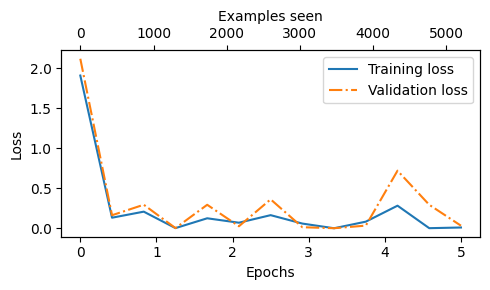

최종 모델 평가 중...
훈련 정확도: 99.90%
검증 정확도: 97.32%
테스트 정확도: 97.67%


In [17]:
main()